Objective: Develop an algorithm which will identify the artist when provided with a painting.  
Reference: https://www.kaggle.com/datasets/ikarus777/best-artworks-of-all-time

During this notebook, we will leverage Google Colab to utilize the power of GPUs, enabling us to execute this project seamlessly without requiring any additional external files.

## Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
from glob import glob
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, Dropout,BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import shutil
from pathlib import Path
import random
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.applications import ResNet50

In [2]:
!git clone https://plmlab.math.cnrs.fr/chevallier-teaching/datasets/art-challenge.git

Cloning into 'art-challenge'...
remote: Enumerating objects: 17127, done.
remote: Total 17127 (delta 0), reused 0 (delta 0), pack-reused 17127 (from 1)
Receiving objects: 100% (17127/17127), 2.16 GiB | 19.44 MiB/s, done.
Resolving deltas: 100% (173/173), done.
Updating files: 100% (16806/16806), done.


##  Exploratory Data Analysis

The goal of this project is to identify the painter of given paintings, the dataset is available on plmlab.math.cnrs.fr/chevallier-teaching/datasets/art-challenge  
The dataset contains three files:  
artists.csv: dataset of information for each artist.  
images_hq: collection of images (full size), divided in folders and sequentially numbered.  
images_lq: same collection but images have been resized and extracted from folder structure


[]

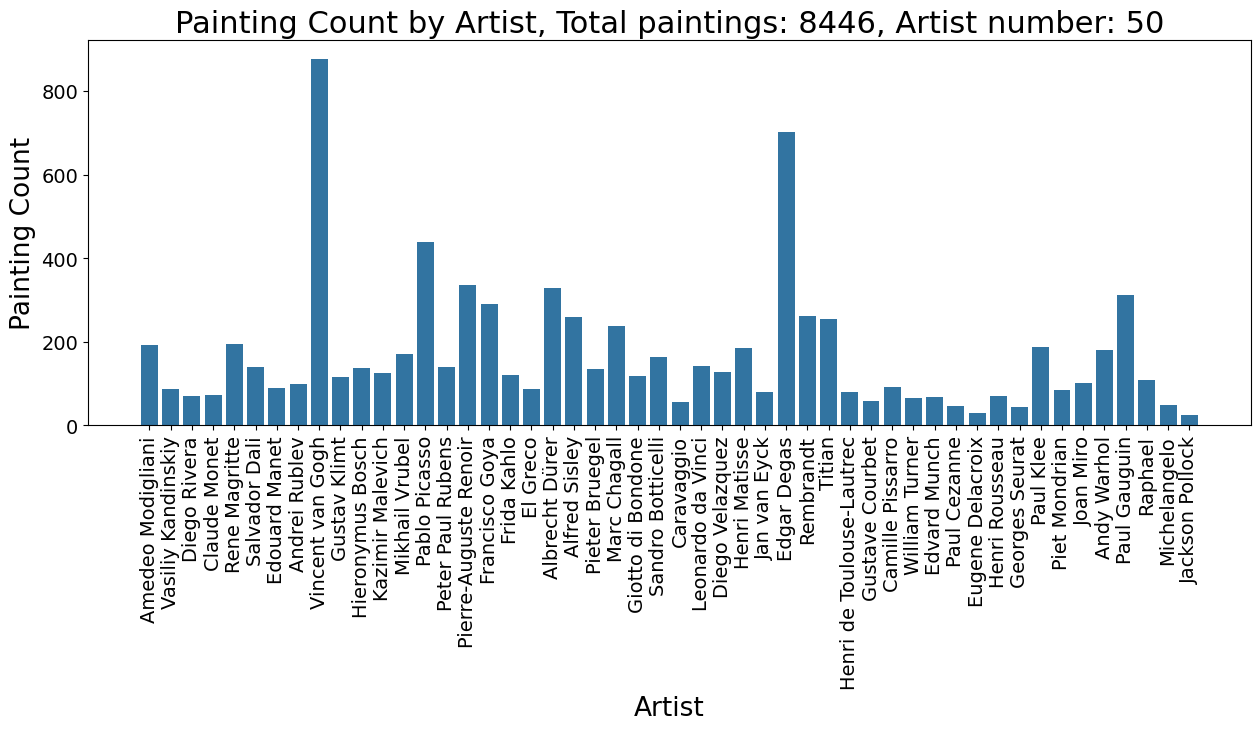

In [3]:
figsize=(15, 5)
ticksize = 14
titlesize = ticksize + 8
labelsize = ticksize + 5
artist=pd.read_csv('/content/art-challenge/artists.csv')
total_paintings = artist['paintings'].sum()
artist_number=artist.shape[0]
params = {'figure.figsize' : figsize,
          'axes.labelsize' : labelsize,
          'axes.titlesize' : titlesize,
          'xtick.labelsize': ticksize,
          'ytick.labelsize': ticksize}

plt.rcParams.update(params)

col1 = "name"
col2 = "paintings"

sns.barplot(x=col1, y=col2, data=artist)
plt.title(f"Painting Count by Artist, Total paintings: {total_paintings}, Artist number: {artist_number}")
plt.xlabel("Artist")
plt.ylabel("Painting Count")
plt.xticks(rotation=90)
plt.plot()

#### Create dataframe with artists having min of 150 paintings.
I have also introduced a new feature called 'class_weight, which assigns weights to the paintings. This feature gives more importance to artists with fewer paintings in the dataset.

In [8]:
# Create a dataframe with artists having more than 200 paintings
artists_top = artist[artist['paintings'] >= 150].reset_index()
artists_top = artists_top[['name', 'paintings']]

artists_top['class_weight'] = artists_top.paintings.sum() / (artists_top.shape[0] * artists_top.paintings)
class_weights = artists_top['class_weight'].to_dict()
total_paintings = artists_top['paintings'].sum()
print(f"So we are considering {total_paintings} paints, and {artists_top.shape[0]} artists.")
images_dir = '/content/art-challenge/images_hq'
artists_top_name = artists_top['name'].str.replace(' ', '_').values
artists_top

So we are considering 5576 paints, and 18 artists.


name  paintings  class_weight
0       Amedeo Modigliani        193      1.605066
1           Rene Magritte        194      1.596793
2        Vincent van Gogh        877      0.353224
3          Mikhail Vrubel        171      1.811566
4           Pablo Picasso        439      0.705644
5   Pierre-Auguste Renoir        336      0.921958
6          Francisco Goya        291      1.064528
7          Albrecht Dürer        328      0.944444
8           Alfred Sisley        259      1.196053
9            Marc Chagall        239      1.296141
10      Sandro Botticelli        164      1.888889
11          Henri Matisse        186      1.665472
12            Edgar Degas        702      0.441279
13              Rembrandt        262      1.182358
14                 Titian        255      1.214815
15              Paul Klee        188      1.647754
16            Andy Warhol        181      1.711479
17           Paul Gauguin        311      0.996070

The code below organizes low quality images into folders based on the artist's name.

In [ ]:
# Répertoire contenant toutes les images
source_folder = Path('/content/art-challenge/images_lq/')

# Répertoire de destination pour organiser les artistes
destination_folder = Path('/content/art-challenge/images_lq/')
destination_folder.mkdir(exist_ok=True)

# Parcourir toutes les images dans le répertoire source
for image_file in source_folder.glob("*.jpg"):  # ou "*.png" selon vos extensions d'image
    # Diviser le nom de fichier en parties
    parts = image_file.stem.split("_")
    # Vérifier si le nom de fichier a au moins deux parties
    if len(parts) >= 4:
    # Si la liste a 4 éléments ou plus, on combine les trois premiers
        artist_name = f"{parts[0]}_{parts[1]}_{parts[2]}"
    elif len(parts) == 3:
    # Si la liste a exactement 3 éléments, on combine les deux premiers
        artist_name = f"{parts[0]}_{parts[1]}"
    else:
    # Si la liste a moins de 3 éléments, on utilise seulement le premier
        artist_name = parts[0]
    # Créer le dossier pour l'artiste s'il n'existe pas encore
    artist_folder = destination_folder / artist_name
    artist_folder.mkdir(exist_ok=True)

    # Déplacer l'image dans le dossier de l'artiste
    shutil.move(str(image_file), artist_folder / image_file.name)
artists_dirs = os.listdir(images_dir)
artists_dirs = os.listdir(images_dir)
# See if all directories exist
for name in artists_top_name:
    if os.path.exists(os.path.join(images_dir, name)):
        print("Found -->", os.path.join(images_dir, name))
    else:
        print("Did not find -->", os.path.join(images_dir, name))

Found --> /content/art-challenge/images_lq/Amedeo_Modigliani
Found --> /content/art-challenge/images_lq/Rene_Magritte
Found --> /content/art-challenge/images_lq/Vincent_van_Gogh
Found --> /content/art-challenge/images_lq/Mikhail_Vrubel
Found --> /content/art-challenge/images_lq/Pablo_Picasso
Found --> /content/art-challenge/images_lq/Pierre-Auguste_Renoir
Found --> /content/art-challenge/images_lq/Francisco_Goya
Found --> /content/art-challenge/images_lq/Albrecht_Dürer
Found --> /content/art-challenge/images_lq/Alfred_Sisley
Found --> /content/art-challenge/images_lq/Marc_Chagall
Found --> /content/art-challenge/images_lq/Sandro_Botticelli
Found --> /content/art-challenge/images_lq/Henri_Matisse
Found --> /content/art-challenge/images_lq/Edgar_Degas
Found --> /content/art-challenge/images_lq/Rembrandt
Found --> /content/art-challenge/images_lq/Titian
Found --> /content/art-challenge/images_lq/Paul_Klee
Found --> /content/art-challenge/images_lq/Andy_Warhol
Found --> /content/art-challe

The following code displays the first 9 paintings of a selected artist.

Pablo_Picasso


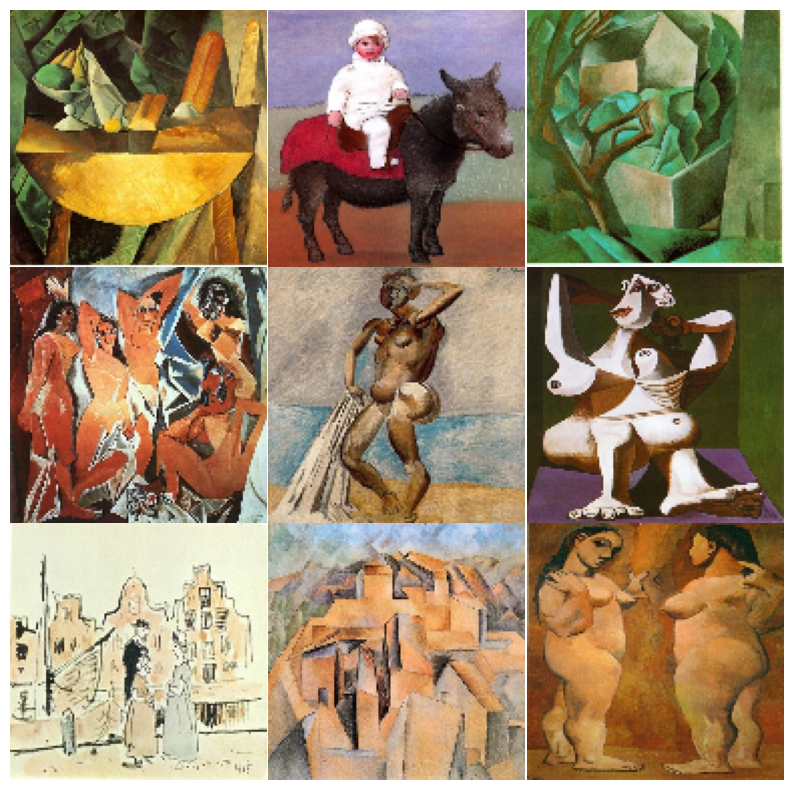

In [ ]:
def plotImages(artist,directory):
    print(artist)
    multipleImages = glob(directory)
    plt.rcParams['figure.figsize'] = (10, 10)
    plt.subplots_adjust(wspace=0, hspace=0)
    i_ = 0
    for l in multipleImages[:9]:
        im = cv2.imread(l)
        im = cv2.resize(im, (128, 128))
        plt.subplot(3,3, i_+1) #.set_title(l)
        plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB)); plt.axis('off')
        i_ += 1
    plt.show()
plotImages("Pablo_Picasso",'/content/art-challenge/images_lq/Pablo_Picasso/**')

The next code selects a random image of an artist and displays it in both low and high resolution.

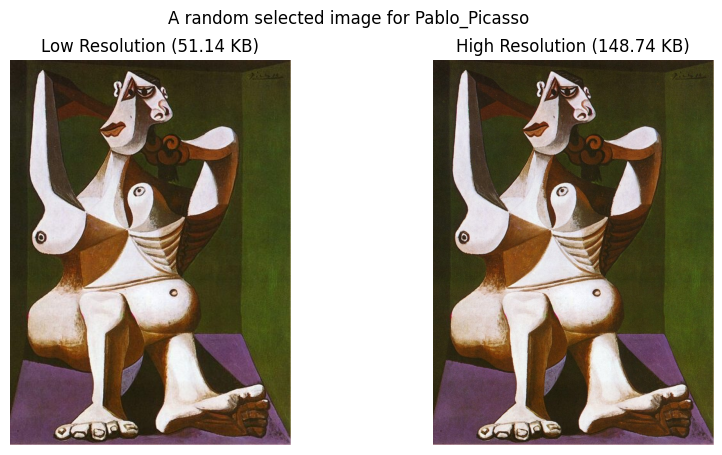

In [ ]:
def plotImageLowHigh(artist):
    # Dossiers pour les images de basse et haute résolution
    low_res_folder = Path(f'/content/art-challenge/images_lq/{artist}/')
    high_res_folder = Path(f'/content/art-challenge/images_hq/{artist}/')

    # Obtenir une image aléatoire dans le dossier de basse résolution
    low_res_images = list(low_res_folder.glob("*.jpg"))
    if not low_res_images:
        print(f"Aucune image trouvée dans {low_res_folder}")
        return

    random_image = random.choice(low_res_images)
    #print(f"Image sélectionnée : {random_image.name}")

    # Construire le chemin de l'image correspondante en haute résolution
    high_res_image_path = high_res_folder / random_image.name

    # Vérifier que les deux images existent
    if not random_image.exists() or not high_res_image_path.exists():
        print(f"Une des images n'existe pas : {random_image} ou {high_res_image_path}")
        return

    # Charger les images
    low_res_img = cv2.imread(str(random_image))
    high_res_img = cv2.imread(str(high_res_image_path))

    # Convertir en RGB pour l'affichage
    low_res_rgb = cv2.cvtColor(low_res_img, cv2.COLOR_BGR2RGB)
    high_res_rgb = cv2.cvtColor(high_res_img, cv2.COLOR_BGR2RGB)

    # Obtenir la taille des fichiers en KB
    low_res_size_kb = random_image.stat().st_size / 1024  # En KB
    high_res_size_kb = high_res_image_path.stat().st_size / 1024  # En KB

    # Afficher les deux images avec les tailles dans les légendes
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(low_res_rgb)
    plt.axis('off')
    plt.title(f"Low Resolution ({low_res_size_kb:.2f} KB)", fontsize=12)

    plt.subplot(1, 2, 2)
    plt.imshow(high_res_rgb)
    plt.axis('off')
    plt.title(f"High Resolution ({high_res_size_kb:.2f} KB)", fontsize=12)
    plt.suptitle(f"A random selected image for " + artist , fontsize=12)
    plt.show()
plotImageLowHigh("Pablo_Picasso")

### Splitting and Data Augmentation

To divide our dataset into three parts, I chose to first manually split it into two parts: training and testing. Then, I used flow_from_directory to apply data augmentation to the training set and further split the test set into validation and test subsets.

In [6]:
from sklearn.model_selection import train_test_split


# Liste des sous-dossiers (chaque sous-dossier représente une classe)
classes = os.listdir(images_dir)

# Séparer les images et labels
image_paths = []
labels = []

for label in classes:
    label_folder = os.path.join(images_dir, label)
    if os.path.isdir(label_folder):
        for img in os.listdir(label_folder):
            image_paths.append(os.path.join(label_folder, img))
            labels.append(label)

# Diviser en ensemble d'entraînement et de test (80% pour l'entraînement et 20% pour le test)
image_paths_train, image_paths_test, labels_train, labels_test = train_test_split(
    image_paths, labels, test_size=0.2, random_state=42, stratify=labels
)

# Créer des dossiers pour entraîner et tester
train_dir = 'train'
test_dir = 'test'

os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Déplacer les fichiers dans les répertoires appropriés
for img_path, label in zip(image_paths_train, labels_train):
    label_dir = os.path.join(train_dir, label)
    os.makedirs(label_dir, exist_ok=True)
    shutil.copy(img_path, label_dir)

for img_path, label in zip(image_paths_test, labels_test):
    label_dir = os.path.join(test_dir, label)
    os.makedirs(label_dir, exist_ok=True)
    shutil.copy(img_path, label_dir)


Augmented data

For training:
Found 4460 images belonging to 18 classes.
For validation:
Found 561 images belonging to 18 classes.
For testing:
Found 555 images belonging to 18 classes.


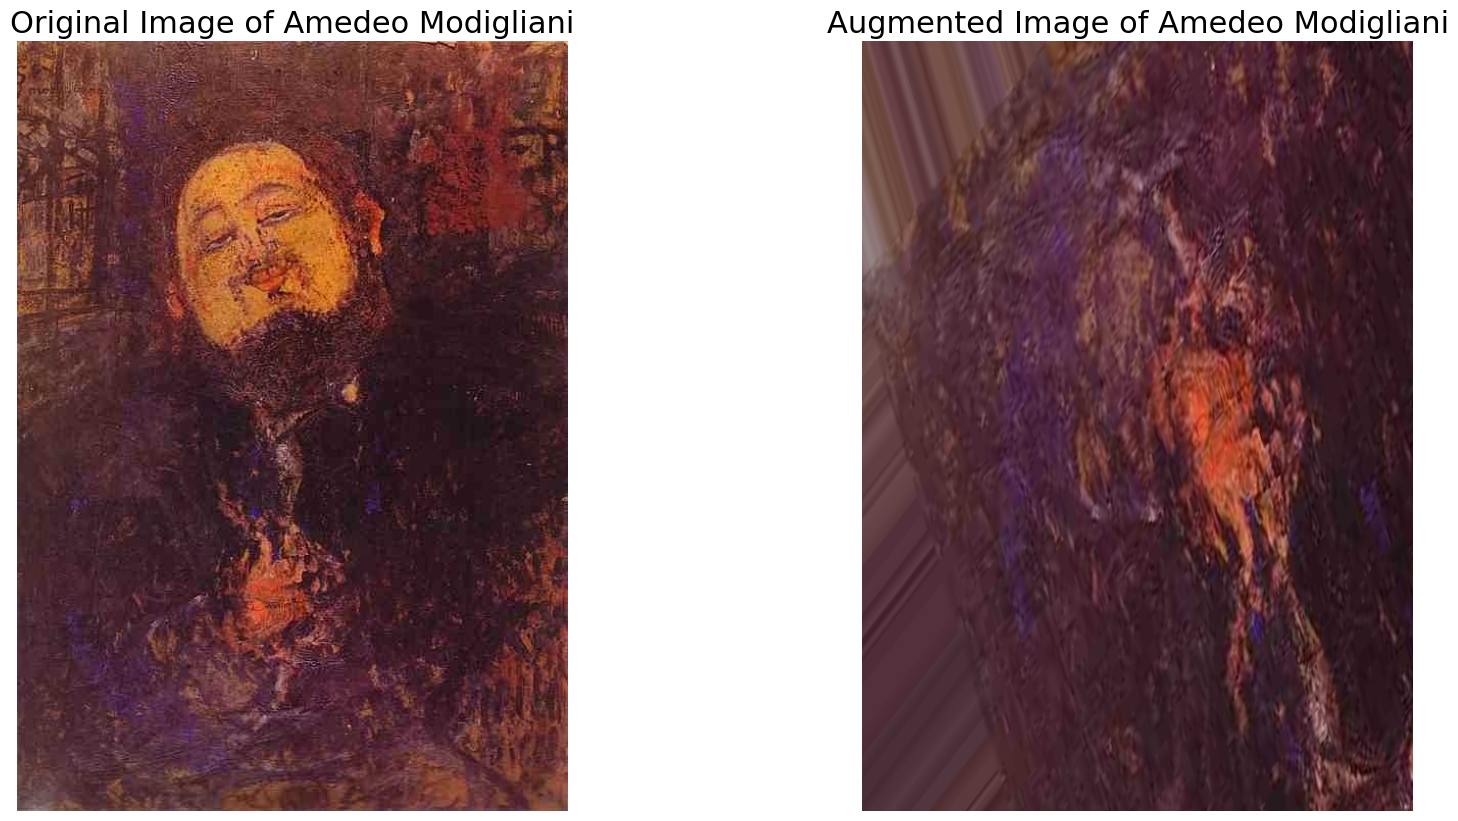

In [9]:
# Augment data
batch_size = 16
train_input_shape = (224, 224, 3)
n_classes = artists_top.shape[0]

train_datagen = ImageDataGenerator(
    rescale=1./255.,       # Normalize pixel values
    rotation_range=45,
    width_shift_range=0.5,
    height_shift_range=0.5,
    shear_range=5,
    zoom_range=0.7,
    horizontal_flip=True,
    vertical_flip=True
)

# Data generator for the validation set (no augmentation, only rescaling)
valid_datagen = ImageDataGenerator(
    validation_split=0.5,  # Same split for consistency
    rescale=1./255.       # Normalize pixel values
)

print("For training:")
train_generator = train_datagen.flow_from_directory(
    directory='/content/train/',
    class_mode='categorical',
    target_size=train_input_shape[0:2],
    batch_size=batch_size,
    shuffle=True,       # Shuffle training data
    classes=artists_top_name.tolist()
)

print("For validation:")
valid_generator = valid_datagen.flow_from_directory(
    directory='/content/test',
    class_mode='categorical',
    target_size=train_input_shape[0:2],
    batch_size=batch_size,
     subset="training",  # Validation subset
    shuffle=False,        # No shuffling for validation
    classes=artists_top_name.tolist()
)
print("For testing:")
test_generator = valid_datagen.flow_from_directory(
    directory='/content/test',
    class_mode='categorical',
    target_size=train_input_shape[0:2],
    batch_size=batch_size,
    subset="validation",  # Validation subset
    shuffle=False,        # No shuffling for validation
    classes=artists_top_name.tolist()
)


STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
#print("Total number of batches =", STEP_SIZE_TRAIN, "and", STEP_SIZE_VALID)

# Visualize original and transformed image
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
random_artist = random.choice(artists_top_name)
random_image = random.choice(os.listdir(os.path.join(images_dir, random_artist)))
random_image_file = os.path.join(images_dir, random_artist, random_image)

image = plt.imread(random_image_file)
axes[0].imshow(image)
axes[0].set_title(f"Original Image of {random_artist.replace('_', ' ')}")
axes[0].axis('off')

aug_image = train_datagen.random_transform(image)
axes[1].imshow(aug_image)
axes[1].set_title(f"Augmented Image of {random_artist.replace('_', ' ')}")
axes[1].axis('off')
plt.show()

#### The following code calculates the number of training images per artist to evaluate the balance of the dataset across different artists.

In [ ]:
print("Class Indices:", train_generator.class_indices)

# Initialize a dictionary to store the count of images for each artist
images_count_per_artist = {artist: 0 for artist in artists_top_name}

# Loop through the batches and count images
for i in range(STEP_SIZE_TRAIN):
    _, labels = train_generator.__next__()
    for j, label in enumerate(labels):
        artist_index = label.argmax()  # Get the index of the artist for the current image
        artist_name = artists_top_name[artist_index]
        images_count_per_artist[artist_name] += 1

# Print the count of images for each artist
print("Number of images trained for each artist:")
for artist, count in images_count_per_artist.items():
    print(f"{artist}: {count} images")

Class Indices: {'Amedeo_Modigliani': 0, 'Rene_Magritte': 1, 'Vincent_van_Gogh': 2, 'Mikhail_Vrubel': 3, 'Pablo_Picasso': 4, 'Pierre-Auguste_Renoir': 5, 'Francisco_Goya': 6, 'Albrecht_Dürer': 7, 'Alfred_Sisley': 8, 'Marc_Chagall': 9, 'Sandro_Botticelli': 10, 'Henri_Matisse': 11, 'Edgar_Degas': 12, 'Rembrandt': 13, 'Titian': 14, 'Paul_Klee': 15, 'Andy_Warhol': 16, 'Paul_Gauguin': 17}
Number of images trained for each artist:
Amedeo_Modigliani: 153 images
Rene_Magritte: 155 images
Vincent_van_Gogh: 699 images
Mikhail_Vrubel: 136 images
Pablo_Picasso: 348 images
Pierre-Auguste_Renoir: 269 images
Francisco_Goya: 232 images
Albrecht_Dürer: 262 images
Alfred_Sisley: 207 images
Marc_Chagall: 191 images
Sandro_Botticelli: 131 images
Henri_Matisse: 149 images
Edgar_Degas: 561 images
Rembrandt: 210 images
Titian: 203 images
Paul_Klee: 150 images
Andy_Warhol: 145 images
Paul_Gauguin: 247 images


## Build Model

### Using ResNet50 as the Base Model

In this section, we will use **ResNet50** as the base model for our task. ResNet50 is known for its identity layers, which implement skip-connections. These connections allow the model to skip certain layers, effectively mitigating the vanishing gradient problem and improving training efficiency.

While the original ResNet model is designed to classify images into 1000 categories from the ImageNet dataset, our objective is to classify images by artist.

#### How to Adapt ResNet50?

With Keras, we can easily adapt ResNet50 to our task by importing only the convolutional layers of the model. This can be done by setting the `include_top` parameter to `False`, which excludes the fully connected layers designed for ImageNet categories. This way, we can customize the model for artist classification.

In [10]:
# Load pre-trained model
conv_base = ResNet50(
    weights = 'imagenet', # We use the network weights already pre-trained on the ImageNet database.
    include_top = False,  # The Dense part of the original network is not retained
    input_shape = train_input_shape
)
for layer in conv_base.layers:
    layer.trainable = True

#conv_base.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


### Create our Convolutional Neural Network

In [11]:
classifier = Flatten()(conv_base.output)

#Initialize the CNN
classifier = Dense(512, activation='relu')(classifier)
classifier = BatchNormalization()(classifier)

classifier= Dense(32, activation='relu')(classifier)
classifier = BatchNormalization()(classifier)

output = Dense(n_classes, activation = 'softmax')(classifier)

model = Model(inputs=conv_base.input, outputs=output)

#### Compile the CNN

In [12]:
model.compile(optimizer = Adam(learning_rate =0.0001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

#### Train Model for the High quality Images
Google colab (GPU)

In [13]:
early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1,
                           mode='auto', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5,
                              verbose=1, mode='auto')

In [14]:
history = model.fit(train_generator, steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator, validation_steps=STEP_SIZE_VALID,
                              epochs=20,
                              shuffle=True,
                              verbose=1,
                              callbacks=[reduce_lr, early_stop]
                             )

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


278/278 ━━━━━━━━━━━━━━━━━━━━ 213s 541ms/step - accuracy: 0.2487 - loss: 2.6373 - val_accuracy: 0.0339 - val_loss: 7.4056 - learning_rate: 1.0000e-04
Epoch 2/20
  1/278 ━━━━━━━━━━━━━━━━━━━━ 1:04 232ms/step - accuracy: 0.3750 - loss: 2.3014

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


278/278 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.3750 - loss: 2.3014 - val_accuracy: 0.0000e+00 - val_loss: 10.9644 - learning_rate: 1.0000e-04
Epoch 3/20
278/278 ━━━━━━━━━━━━━━━━━━━━ 122s 373ms/step - accuracy: 0.4899 - loss: 1.8411 - val_accuracy: 0.0804 - val_loss: 4.0289 - learning_rate: 1.0000e-04
Epoch 4/20
278/278 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4375 - loss: 2.1623 - val_accuracy: 0.0000e+00 - val_loss: 3.3683 - learning_rate: 1.0000e-04
Epoch 5/20
278/278 ━━━━━━━━━━━━━━━━━━━━ 138s 365ms/step - accuracy: 0.5506 - loss: 1.5513 - val_accuracy: 0.1911 - val_loss: 3.4814 - learning_rate: 1.0000e-04
Epoch 6/20
278/278 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7500 - loss: 1.2272 - val_accuracy: 0.0000e+00 - val_loss: 2.5025 - learning_rate: 1.0000e-04
Epoch 7/20
278/278 ━━━━━━━━━━━━━━━━━━━━ 104s 366ms/step - accuracy: 0.5926 - loss: 1.4213 - val_accuracy: 0.5821 - val_loss: 1.5789 - learning_rate: 1.0000e-04
Epoch 8/20
278/278 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/ste

the learning curve at this stage is

Text(0.5, 1.0, 'Train - Accuracy')

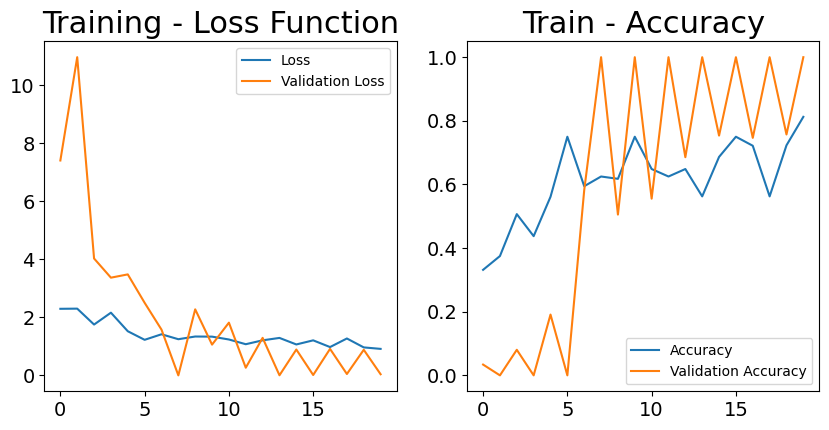

In [16]:
plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training - Loss Function')

plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Train - Accuracy')

#### Fine tuning the model

Freezing a layer prevents its weights from being modified. This technique is often used in transfer learning, where the base model(trained on some other dataset)is frozen indicating that this layer should not be trained

In [17]:
# Freeze core ResNet layers and train again
for layer in model.layers:
    layer.trainable = False

for layer in model.layers[:50]:
    layer.trainable = True

optimizer = Adam(learning_rate =0.0001)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])
history2 = model.fit(train_generator, steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator, validation_steps=STEP_SIZE_VALID,
                              epochs=50,
                              shuffle=True,
                              verbose=1,
                              callbacks=[reduce_lr, early_stop]
                             )

Epoch 1/50
278/278 ━━━━━━━━━━━━━━━━━━━━ 145s 433ms/step - accuracy: 0.6606 - loss: 1.1855 - val_accuracy: 0.7125 - val_loss: 0.9999 - learning_rate: 1.0000e-04
Epoch 2/50
278/278 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6250 - loss: 1.1500 - val_accuracy: 1.0000 - val_loss: 6.3656e-05 - learning_rate: 1.0000e-04
Epoch 3/50
278/278 ━━━━━━━━━━━━━━━━━━━━ 96s 340ms/step - accuracy: 0.6691 - loss: 1.1298 - val_accuracy: 0.7125 - val_loss: 1.0714 - learning_rate: 1.0000e-04
Epoch 4/50
278/278 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6250 - loss: 1.0304 - val_accuracy: 1.0000 - val_loss: 1.9550e-05 - learning_rate: 1.0000e-04
Epoch 5/50
278/278 ━━━━━━━━━━━━━━━━━━━━ 96s 338ms/step - accuracy: 0.6971 - loss: 1.0786 - val_accuracy: 0.7375 - val_loss: 1.0214 - learning_rate: 1.0000e-04
Epoch 6/50
278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 125us/step - accuracy: 0.7500 - loss: 0.7688 - val_accuracy: 1.0000 - val_loss: 0.0066 - learning_rate: 1.0000e-04
Epoch 7/50
278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 3

Using this architecture, the resulting training and validation curves observed over the epochs are as follows:

Text(0.5, 1.0, 'Train - Accuracy')

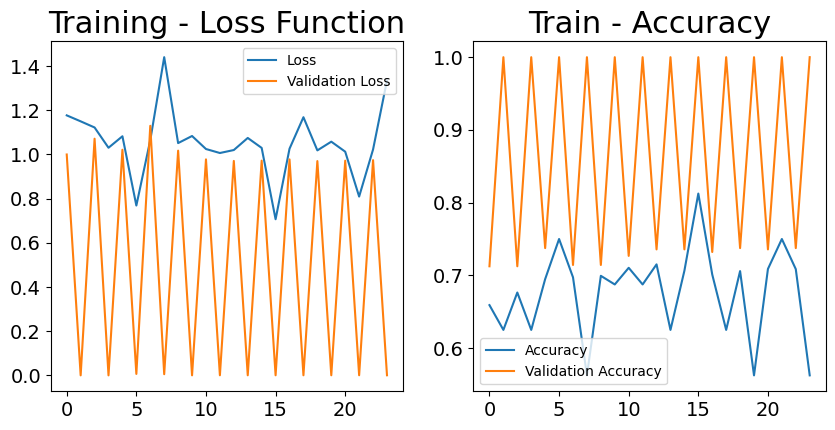

In [18]:
plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.plot(history2.history['loss'], label='Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training - Loss Function')

plt.subplot(2, 2, 2)
plt.plot(history2.history['accuracy'], label='Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Train - Accuracy')


#### Test Model

Now, we will use our previously unused testing dataset to evaluate the performance.

In [19]:
y_trues = test_generator.labels
y_preds = model.predict(test_generator, verbose=1)
y_preds = y_preds.argmax(axis=1)

35/35 ━━━━━━━━━━━━━━━━━━━━ 12s 268ms/step


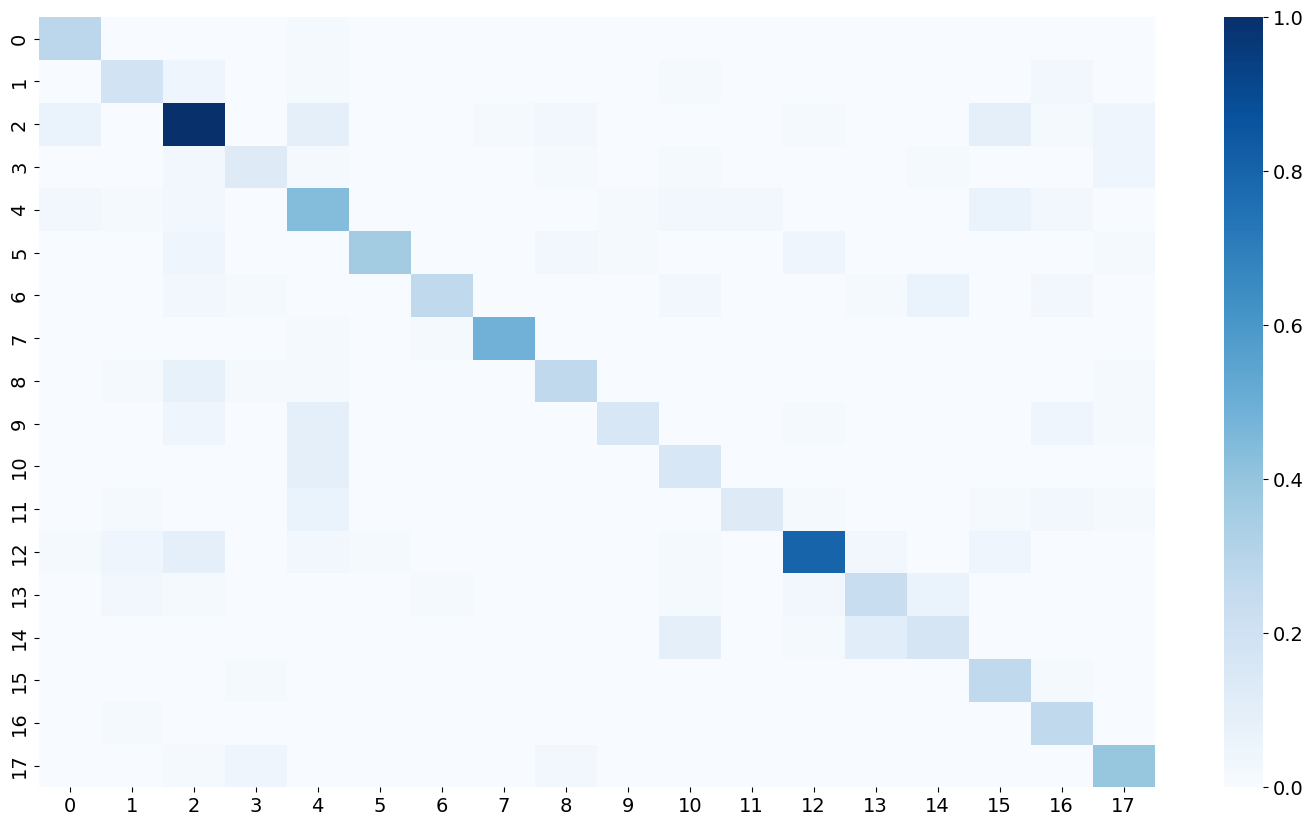

In [20]:
from sklearn import metrics
matrix = metrics.confusion_matrix(y_trues, y_preds)

plt.figure(figsize = (18,10))
sns.heatmap(matrix/np.max(matrix), cmap='Blues')
plt.show()



In [26]:


from sklearn import metrics
print(metrics.classification_report(y_trues, y_preds, digits=3))



              precision    recall  f1-score   support

           0      0.720     0.947     0.818        19
           1      0.571     0.632     0.600        19
           2      0.696     0.727     0.711        88
           3      0.571     0.471     0.516        17
           4      0.491     0.636     0.554        44
           5      0.958     0.697     0.807        33
           6      0.895     0.586     0.708        29
           7      0.969     0.939     0.954        33
           8      0.708     0.654     0.680        26
           9      0.833     0.417     0.556        24
          10      0.417     0.625     0.500        16
          11      0.800     0.444     0.571        18
          12      0.850     0.729     0.785        70
          13      0.600     0.577     0.588        26
          14      0.550     0.440     0.489        25
          15      0.548     0.895     0.680        19
          16      0.567     0.944     0.708        18
          17      0.714    

I can conclude that our model performs adequately; however, the dataset may still be insufficient to enable the model to learn more effectively.  Let us try
### another architecture for the High quality images

In [30]:
classifier = Flatten()(conv_base.output)

#Initialize the CNN
classifier = Dense(512, activation='relu')(classifier)
classifier = BatchNormalization()(classifier)
classifier = Dropout(0.5)(classifier)
classifier= Dense(256, activation='relu')(classifier)
classifier = BatchNormalization()(classifier)

classifier= Dense(16, activation='relu')(classifier)
classifier = BatchNormalization()(classifier)


output = Dense(n_classes, activation = 'softmax')(classifier)

model2 = Model(inputs=conv_base.input, outputs=output)


In [31]:
model2.compile(optimizer = Adam(learning_rate =0.0001), loss = 'categorical_crossentropy', metrics = ['accuracy'])


In [32]:
history = model2.fit(train_generator, steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator, validation_steps=STEP_SIZE_VALID,
                              epochs=20,
                              shuffle=True,
                              verbose=1,
                              callbacks=[reduce_lr, early_stop]
                             )

Epoch 1/20
278/278 ━━━━━━━━━━━━━━━━━━━━ 143s 417ms/step - accuracy: 0.3561 - loss: 2.2551 - val_accuracy: 0.6732 - val_loss: 1.2982 - learning_rate: 1.0000e-04
Epoch 2/20
  1/278 ━━━━━━━━━━━━━━━━━━━━ 32s 117ms/step - accuracy: 0.5000 - loss: 1.8433

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


278/278 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5000 - loss: 1.8433 - val_accuracy: 1.0000 - val_loss: 0.0960 - learning_rate: 1.0000e-04
Epoch 3/20
278/278 ━━━━━━━━━━━━━━━━━━━━ 97s 341ms/step - accuracy: 0.5518 - loss: 1.7472 - val_accuracy: 0.6929 - val_loss: 1.2130 - learning_rate: 1.0000e-04
Epoch 4/20
278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 113us/step - accuracy: 0.6250 - loss: 1.4136 - val_accuracy: 1.0000 - val_loss: 0.1504 - learning_rate: 1.0000e-04
Epoch 5/20
278/278 ━━━━━━━━━━━━━━━━━━━━ 98s 347ms/step - accuracy: 0.6235 - loss: 1.5507 - val_accuracy: 0.5946 - val_loss: 1.5541 - learning_rate: 1.0000e-04
Epoch 6/20
278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 111us/step - accuracy: 0.6250 - loss: 1.2616 - val_accuracy: 1.0000 - val_loss: 0.2509 - learning_rate: 1.0000e-04
Epoch 7/20
278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.6251 - loss: 1.5262
Epoch 7: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
278/278 ━━━━━━━━━━━━━━━━━━━━ 102s 358ms/step - accuracy: 

It is worth noting that the code retains the first epoch because it has been executed multiple times.

#### Fine tuning the second model for HQ

In [33]:

for layer in model.layers:
    layer.trainable = False

for layer in model.layers[:50]:
    layer.trainable = True

optimizer = Adam(learning_rate =0.0001)

model2.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])
history2 = model2.fit(train_generator, steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator, validation_steps=STEP_SIZE_VALID,
                              epochs=50,
                              shuffle=True,
                              verbose=1,
                              callbacks=[reduce_lr, early_stop]
                             )

Epoch 1/50
278/278 ━━━━━━━━━━━━━━━━━━━━ 135s 393ms/step - accuracy: 0.5602 - loss: 1.7547 - val_accuracy: 0.7036 - val_loss: 1.2057 - learning_rate: 1.0000e-04
Epoch 2/50
  1/278 ━━━━━━━━━━━━━━━━━━━━ 34s 123ms/step - accuracy: 0.5625 - loss: 1.6290

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


278/278 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.5625 - loss: 1.6290 - val_accuracy: 1.0000 - val_loss: 0.3221 - learning_rate: 1.0000e-04
Epoch 3/50
278/278 ━━━━━━━━━━━━━━━━━━━━ 100s 352ms/step - accuracy: 0.6046 - loss: 1.6126 - val_accuracy: 0.7196 - val_loss: 1.1297 - learning_rate: 1.0000e-04
Epoch 4/50
278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 148us/step - accuracy: 0.6250 - loss: 1.3131 - val_accuracy: 1.0000 - val_loss: 0.1531 - learning_rate: 1.0000e-04
Epoch 5/50
278/278 ━━━━━━━━━━━━━━━━━━━━ 144s 360ms/step - accuracy: 0.6324 - loss: 1.5098 - val_accuracy: 0.6893 - val_loss: 1.1929 - learning_rate: 1.0000e-04
Epoch 6/50
278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 121us/step - accuracy: 0.6875 - loss: 1.3069 - val_accuracy: 1.0000 - val_loss: 0.1652 - learning_rate: 1.0000e-04
Epoch 7/50
278/278 ━━━━━━━━━━━━━━━━━━━━ 136s 342ms/step - accuracy: 0.6441 - loss: 1.4237 - val_accuracy: 0.6125 - val_loss: 1.4397 - learning_rate: 1.0000e-04
Epoch 8/50
278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 112us/step - ac

Using this architecture, the resulting training and validation curves observed over the epochs are as follows:

Text(0.5, 1.0, 'Train - Accuracy')

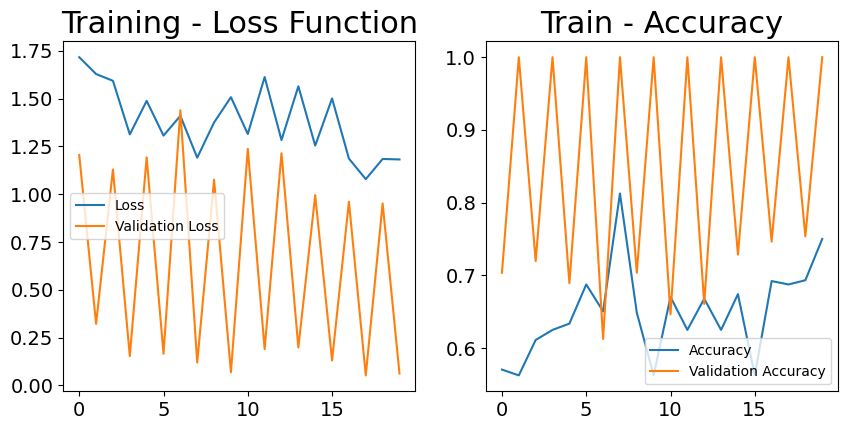

In [34]:
plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.plot(history2.history['loss'], label='Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training - Loss Function')

plt.subplot(2, 2, 2)
plt.plot(history2.history['accuracy'], label='Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Train - Accuracy')


In [35]:
y_trues = test_generator.labels
y_preds = model.predict(test_generator, verbose=1)
y_preds = y_preds.argmax(axis=1)

35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step


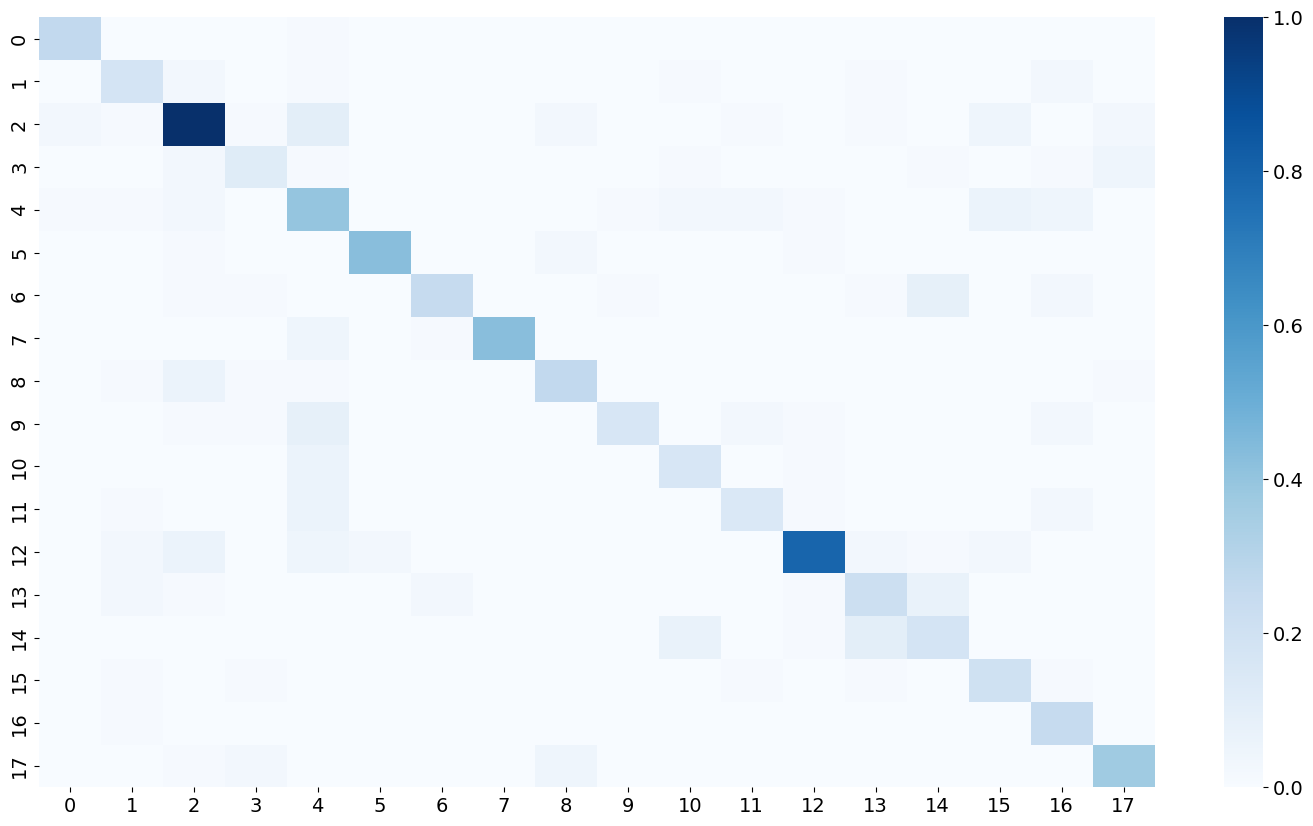

In [36]:
matrix = metrics.confusion_matrix(y_trues, y_preds)

plt.figure(figsize = (18,10))
sns.heatmap(matrix/np.max(matrix), cmap='Blues')
plt.show()

In [37]:
print(metrics.classification_report(y_trues, y_preds, digits=3))

              precision    recall  f1-score   support

           0      0.857     0.947     0.900        19
           1      0.545     0.632     0.585        19
           2      0.782     0.773     0.777        88
           3      0.533     0.471     0.500        17
           4      0.466     0.614     0.529        44
           5      0.935     0.879     0.906        33
           6      0.850     0.586     0.694        29
           7      1.000     0.879     0.935        33
           8      0.720     0.692     0.706        26
           9      0.846     0.458     0.595        24
          10      0.550     0.688     0.611        16
          11      0.625     0.556     0.588        18
          12      0.885     0.771     0.824        70
          13      0.536     0.577     0.556        26
          14      0.480     0.480     0.480        25
          15      0.609     0.737     0.667        19
          16      0.567     0.944     0.708        18
          17      0.806    

#### Let's select a random file from the dataset.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


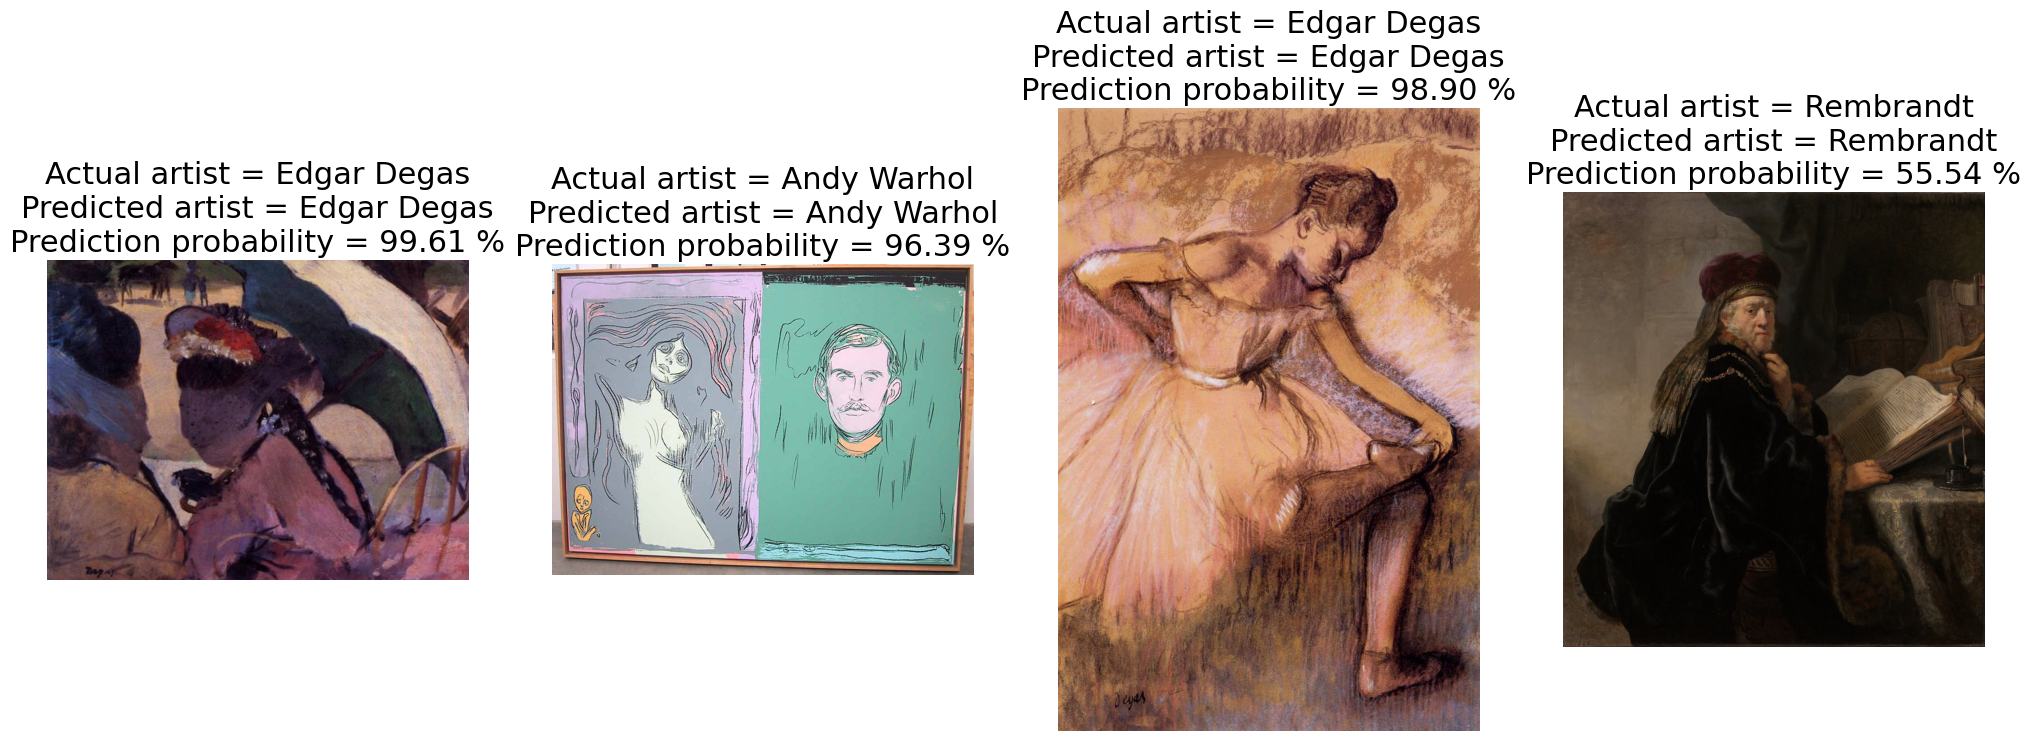

In [38]:
# Prediction
from keras.preprocessing import *

n = 4
fig, axes = plt.subplots(1, n, figsize=(25,10))

for i in range(n):
    random_artist = random.choice(artists_top_name)
    random_image = random.choice(os.listdir(os.path.join(images_dir, random_artist)))
    random_image_file = os.path.join(images_dir, random_artist, random_image)

    # Original image

    test_image = image.load_img(random_image_file, target_size=(train_input_shape[0:2]))

    # Predict artist
    test_image = image.img_to_array(test_image)
    test_image /= 255.
    test_image = np.expand_dims(test_image, axis=0)

    prediction = model.predict(test_image)
    prediction_probability = np.amax(prediction)
    prediction_idx = np.argmax(prediction)

    labels = train_generator.class_indices
    labels = dict((v,k) for k,v in labels.items())

    title = "Actual artist = {}\nPredicted artist = {}\nPrediction probability = {:.2f} %" \
                .format(random_artist.replace('_', ' '), labels[prediction_idx].replace('_', ' '),
                        prediction_probability*100)

    # Print image
    axes[i].imshow(plt.imread(random_image_file))
    axes[i].set_title(title)
    axes[i].axis('off')

plt.show()

## Train Model for the Low quality Images

In the following, we will repeat the process using low-quality images and compare the performance.

In [ ]:
history = model.fit(train_generator, steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator, validation_steps=STEP_SIZE_VALID,
                              epochs=20,
                              shuffle=True,
                              verbose=1,
                              callbacks=[reduce_lr, early_stop]
                             )

Epoch 1/20
278/278 ━━━━━━━━━━━━━━━━━━━━ 170s 421ms/step - accuracy: 0.2646 - loss: 2.5671 - val_accuracy: 0.0429 - val_loss: 5.8238 - learning_rate: 1.0000e-04
Epoch 2/20
  1/278 ━━━━━━━━━━━━━━━━━━━━ 47s 171ms/step - accuracy: 0.1875 - loss: 2.4257

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


278/278 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1875 - loss: 2.4257 - val_accuracy: 0.0000e+00 - val_loss: 6.9094 - learning_rate: 1.0000e-04
Epoch 3/20
278/278 ━━━━━━━━━━━━━━━━━━━━ 85s 300ms/step - accuracy: 0.4762 - loss: 1.7759 - val_accuracy: 0.0786 - val_loss: 4.7713 - learning_rate: 1.0000e-04
Epoch 4/20
278/278 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5625 - loss: 1.5811 - val_accuracy: 0.0000e+00 - val_loss: 6.7605 - learning_rate: 1.0000e-04
Epoch 5/20
278/278 ━━━━━━━━━━━━━━━━━━━━ 141s 301ms/step - accuracy: 0.5512 - loss: 1.5702 - val_accuracy: 0.2036 - val_loss: 3.8536 - learning_rate: 1.0000e-04
Epoch 6/20
278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 135us/step - accuracy: 0.4375 - loss: 1.7000 - val_accuracy: 0.0000e+00 - val_loss: 4.1184 - learning_rate: 1.0000e-04
Epoch 7/20
278/278 ━━━━━━━━━━━━━━━━━━━━ 140s 300ms/step - accuracy: 0.6032 - loss: 1.3919 - val_accuracy: 0.6643 - val_loss: 1.2688 - learning_rate: 1.0000e-04
Epoch 8/20
278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 124us/s

In [ ]:
# Freeze core ResNet layers and train again
for layer in model.layers:
    layer.trainable = False

for layer in model.layers[:50]:
    layer.trainable = True

optimizer = Adam(learning_rate =0.0001)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])
history2 = model.fit(train_generator, steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator, validation_steps=STEP_SIZE_VALID,
                              epochs=50,
                              shuffle=True,
                              verbose=1,
                              callbacks=[reduce_lr, early_stop]
                             )

Epoch 1/50
278/278 ━━━━━━━━━━━━━━━━━━━━ 112s 326ms/step - accuracy: 0.7433 - loss: 0.9113 - val_accuracy: 0.7893 - val_loss: 0.7198 - learning_rate: 1.0000e-04
Epoch 2/50
  1/278 ━━━━━━━━━━━━━━━━━━━━ 31s 114ms/step - accuracy: 0.7500 - loss: 0.7773

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


278/278 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7500 - loss: 0.7773 - val_accuracy: 1.0000 - val_loss: 0.0699 - learning_rate: 1.0000e-04
Epoch 3/50
278/278 ━━━━━━━━━━━━━━━━━━━━ 78s 275ms/step - accuracy: 0.7662 - loss: 0.8265 - val_accuracy: 0.8089 - val_loss: 0.6713 - learning_rate: 1.0000e-04
Epoch 4/50
278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 130us/step - accuracy: 0.9375 - loss: 0.4349 - val_accuracy: 1.0000 - val_loss: 0.2876 - learning_rate: 1.0000e-04
Epoch 5/50
278/278 ━━━━━━━━━━━━━━━━━━━━ 78s 275ms/step - accuracy: 0.7547 - loss: 0.8233 - val_accuracy: 0.7679 - val_loss: 0.7662 - learning_rate: 1.0000e-04
Epoch 6/50
278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 118us/step - accuracy: 0.6250 - loss: 1.0993 - val_accuracy: 1.0000 - val_loss: 0.7356 - learning_rate: 1.0000e-04
Epoch 7/50
278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.7774 - loss: 0.7689
Epoch 7: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
278/278 ━━━━━━━━━━━━━━━━━━━━ 78s 276ms/step - accuracy: 0

 the resulting training and validation curves observed over the epochs are as follows:

Text(0.5, 1.0, 'Train - Accuracy')

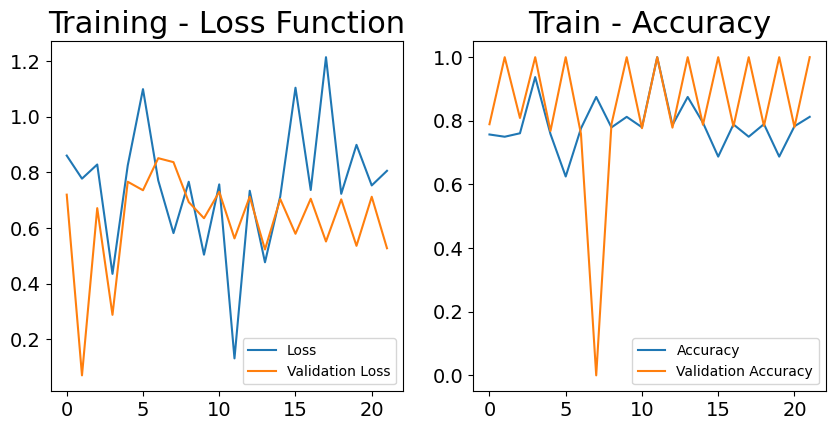

In [ ]:
plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.plot(history2.history['loss'], label='Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training - Loss Function')

plt.subplot(2, 2, 2)
plt.plot(history2.history['accuracy'], label='Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Train - Accuracy')


### Testing results

In [ ]:
y_trues = test_generator.labels
y_preds = model.predict(test_generator, verbose=1)
y_preds = y_preds.argmax(axis=1)

35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 140ms/step


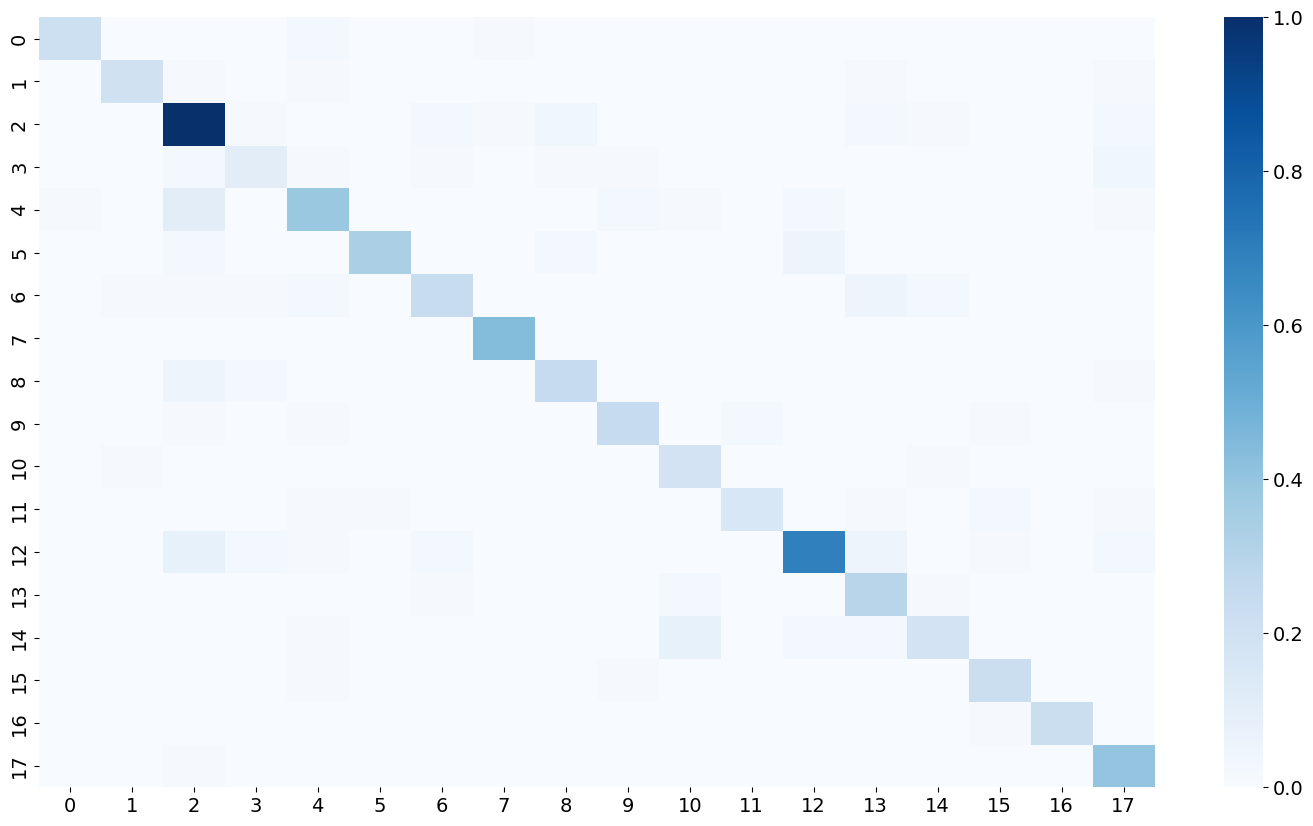

In [ ]:
matrix = metrics.confusion_matrix(y_trues, y_preds)

plt.figure(figsize = (18,10))
sns.heatmap(matrix/np.max(matrix), cmap='Blues')
plt.show()